In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import sklearn.model_selection

from sklearn.cross_validation import KFold;

get_ipython().magic(u'matplotlib inline')
pd.options.display.max_columns = None
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pprint

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
TEST = True

In [3]:
train = pd.read_csv(r'./AnalyticsChallenge1-Train.csv')
test = pd.read_csv(r'./AnalyticsChallenge1-Testing.csv')

EmployeeID = test['EmployeeNumber']

In [4]:
train.isnull().values.any()

False

In [5]:
train.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

In [6]:
train.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,27,No,Travel_Rarely,1103,Research & Development,14,3,Life Sciences,1,1244,1,Male,42,3,1,Research Scientist,1,Married,2235,14377,1,Y,Yes,14,3,4,80,2,9,3,2,9,7,6,8
1,31,Yes,Travel_Frequently,667,Sales,1,4,Life Sciences,1,1427,2,Female,50,1,1,Sales Representative,3,Single,1359,16154,1,Y,No,12,3,2,80,0,1,3,3,1,0,0,0
2,38,No,Travel_Rarely,345,Sales,10,2,Life Sciences,1,2041,1,Female,100,3,2,Sales Executive,4,Married,5343,5982,1,Y,No,11,3,3,80,1,10,1,3,10,7,1,9
3,40,Yes,Travel_Rarely,1329,Research & Development,7,3,Life Sciences,1,1649,1,Male,73,3,1,Laboratory Technician,1,Single,2166,3339,3,Y,Yes,14,3,2,80,0,10,3,1,4,2,0,3
4,33,No,Travel_Frequently,827,Research & Development,1,4,Other,1,998,3,Female,84,4,2,Healthcare Representative,2,Married,5488,20161,1,Y,Yes,13,3,1,80,1,6,2,3,6,5,1,2


In [7]:
train.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.0,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.0,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,36.797500,807.315833,9.141667,2.894167,1.0,1014.035833,2.708333,66.108333,2.747500,2.060000,2.740833,6486.90250,14441.413333,2.680000,15.156667,3.145000,2.705833,80.0,0.791667,11.361667,2.800833,2.753333,7.109167,4.270000,2.222500,4.170000
std,9.165779,401.864555,8.103785,1.033048,0.0,605.333838,1.096631,20.341536,0.715894,1.109396,1.090714,4718.58358,7152.650082,2.495888,3.599711,0.352248,1.093296,0.0,0.841935,7.806193,1.294564,0.721981,6.246447,3.664691,3.267806,3.610905
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.00000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,471.000000,2.000000,2.000000,1.0,475.500000,2.000000,48.750000,2.000000,1.000000,2.000000,2935.75000,8199.500000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,35.000000,806.000000,7.000000,3.000000,1.0,1009.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4880.50000,14434.000000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1158.250000,14.000000,4.000000,1.0,1552.500000,4.000000,84.000000,3.000000,3.000000,4.000000,8197.75000,20701.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.250000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.00000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


In [8]:
full_data = [train, test]

### Create new features
Using existing features, assume somethings and merge them

In [9]:
def has_as_degree(edu):
    return 1 if edu >= 2 else 0

def has_bs_degree(edu):
    return 1 if edu >= 3 else 0

def has_ms_degree(edu):
    return 1 if edu >= 4 else 0

def has_phd_degree(edu):
    return 1 if edu == 5 else 0

def got_promoted(p):
    return 1 if p != 0 else 0

def in_same_company(row):
    if row['YearsAtCompany'] == row['TotalWorkingYears']:
        return 1
    return 0

def in_new_role(row):
    if row['YearsInCurrentRole'] <= 1:
        return 1
    return 0

def is_with_manager_that_is_new(row):
    if row['YearsWithCurrManager'] <=1 and row['YearsInCurrentRole'] > row['YearsWithCurrManager']:
        return 1
    return 0

def in_same_role(row):
    if row['YearsInCurrentRole'] == row['YearsAtCompany']:
        return 1
    return 0

def is_with_same_manager(row):
    if row['YearsWithCurrManager'] == row['YearsInCurrentRole']:
        return 1
    return 0

def is_first_ever_job(row):
    if row['NumCompaniesWorked'] == 0:
        return 1
    return 0

def is_employee(row):
    employee_roles = ['Research Scientist',
                      'Laboratory Technician',
                      'Healthcare Representative',
                      'Sales Representative',
                      'Human Resources']
    for role in employee_roles:
        if role in row['JobRole']:
            return 1
    return 0

def is_manager(row):
    manager_roles = ['Manager']
    for role in manager_roles:
        if role in row['JobRole']:
            return 1
    return 0

def is_executive(row):
    executive_roles = ['Sales Executive']
    for role in executive_roles:
        if role in row['JobRole']:
            return 1
    return 0

def is_board(row):
    board_roles = ['Manufacturing Director',
                   'Research Director']
    for role in board_roles:
        if role in row['JobRole']:
            return 1
    return 0

def is_promoted(row):
    if row['YearsSinceLastPromotion'] == 1:
        return 1
    return 0

def does_edu_match_role(row):
    role_to_degree = {
                      'Sales Executive' : ['Marketing', 'Life Sciencces', 'Medical'],
                      'Research Scientist' : ['Life Sciences', 'Medical'],
                      'Laboratory Technician' : ['Life Sciences', 'Medical', 'Technical Degree'],
                      'Healthcare Representative' : ['Life Sciences', 'Medical'],
                      'Manufacturing Director' : ['Life Sciences', 'Medical', 'Technical Degree'],
                      'Manager' : [],
                      'Sales Representative' : ['Marketing', 'Life Sciences', 'Medical'],
                      'Research Director' : ['Life Sciences', 'Medical'],
                      'Human Resources' : ['Human Resources'],
                     }
    if row['JobRole'] == 'Manager':
        return 1
    if row['EducationField'] in role_to_degree[row['JobRole']]:
        return 1
    return 0

def is_junior(row):
    if row['YearsInCurrentRole'] <= 2:
        return 1
    return 0

def is_mid_level(row):
    if row['YearsInCurrentRole'] > 2 and row['YearsInCurrentRole'] < 10:
        return 1
    return 0

def is_senior(row):
    if row['YearsInCurrentRole'] >= 10:
        return 1
    return 0

def never_promoted(row):
    if row['YearsAtCompany'] == row['YearsSinceLastPromotion']:
        return 1
    return 0

In [10]:
for dataset in full_data:
    
    #isFirstEverJob
    dataset['isFirstEverJob'] = dataset.apply(lambda row: is_first_ever_job(row), axis=1)
    
    #isSameJob
    dataset['inSameCompany'] = dataset.apply(lambda row: in_same_company(row), axis=1)
    
    
    #recentlyPromoted
    dataset['recentlyPromoted'] = dataset.apply(lambda row: is_promoted(row), axis=1)
    
    #neverPromoted
    dataset['neverPromoted'] = dataset.apply(lambda row: never_promoted(row), axis=1)
    
    
    #isEmployee
    dataset['isEmployee'] = dataset.apply(lambda row: is_employee(row), axis=1)
    
    #isManager
    dataset['isManager'] = dataset.apply(lambda row: is_manager(row), axis=1)
    
    #isExecutive
    dataset['isExecutive'] = dataset.apply(lambda row: is_executive(row), axis=1)
    
    #isBoard
    dataset['isBoard'] = dataset.apply(lambda row: is_board(row), axis=1)
    
    
    #withNewManager
    dataset['withManagerThatIsNew'] = dataset.apply(lambda row: is_with_manager_that_is_new(row), axis=1)
    
    #withSameManager
    dataset['withSameManager'] = dataset.apply(lambda row: is_with_same_manager(row), axis=1)
    
    
    #doesEduMatchRole
    dataset['doesEduMatchRole'] = dataset.apply(lambda row: does_edu_match_role(row), axis=1)
    
    #hasASDegree
    dataset['hasASDegree'] = dataset['Education'].apply(has_as_degree)
    
    #hasBSDegree
    dataset['hasBSDegree'] = dataset['Education'].apply(has_bs_degree)
    
    #hasMastersDegree
    dataset['hasMSDegree'] = dataset['Education'].apply(has_ms_degree)
    
    #hasPhDDegree
    dataset['hasPhDDegree'] = dataset['Education'].apply(has_phd_degree)
    
    
    #isJunior
    dataset['isJunior'] = dataset.apply(lambda row: is_junior(row), axis=1)
    
    #isMidLevel
    dataset['isMidLevel'] = dataset.apply(lambda row: is_mid_level(row), axis=1)
    
    #isSenior
    dataset['isSenior'] = dataset.apply(lambda row: is_senior(row), axis=1)
    
    
    #inNewRole
    dataset['inNewRole'] = dataset.apply(lambda row: in_new_role(row), axis=1)
    
    #inSameRole
    dataset['inSameRole'] = dataset.apply(lambda row: in_same_role(row), axis=1)

### Normalize data to ordinal values
Now normalize values for algothrims that interpret numbers as ordinal

In [11]:
def normalize_daily_rate(num):
    return int(num / 100)

def normalize_hourly_rate(num):
    return int(num / 10)

def normalize_monthly_income(num):
    return int(num / 1000)

def normalize_monthly_rate(num):
    return int(num / 1000)

train.Attrition = train.Attrition.map({'No':0, 'Yes':1})

for dataset in full_data:
    #Map Age
    dataset.loc[dataset['Age'] <= 20, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 25) , 'Age'] = 1
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 30) , 'Age'] = 2
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 35) , 'Age'] = 3
    dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 40) , 'Age'] = 4
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 45) , 'Age'] = 5
    dataset.loc[(dataset['Age'] > 45) & (dataset['Age'] <= 50) , 'Age'] = 6
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 55) , 'Age'] = 7
    dataset.loc[dataset['Age'] > 55, 'Age'] = 8
    
#     Map DailyRate
    dataset.loc[:,'DailyRate'] = dataset.loc[:,'DailyRate'].apply(normalize_daily_rate)

    #Map DistanceFromHome
    dataset.loc[dataset['DistanceFromHome'] <= 2, 'DistanceFromHome'] = 0
    dataset.loc[(dataset['DistanceFromHome'] > 2) & (dataset['DistanceFromHome'] <= 5) , 'DistanceFromHome'] = 1
    dataset.loc[(dataset['DistanceFromHome'] > 5) & (dataset['DistanceFromHome'] <= 10) , 'DistanceFromHome'] = 2
    dataset.loc[(dataset['DistanceFromHome'] > 10) & (dataset['DistanceFromHome'] <= 15) , 'DistanceFromHome'] = 3
    dataset.loc[(dataset['DistanceFromHome'] > 15) & (dataset['DistanceFromHome'] <= 20) , 'DistanceFromHome'] = 4
    dataset.loc[(dataset['DistanceFromHome'] > 20) & (dataset['DistanceFromHome'] <= 25) , 'DistanceFromHome'] = 5
    dataset.loc[dataset['DistanceFromHome'] > 25, 'DistanceFromHome'] = 6
    
#     Map HourlyRate
    dataset.loc[:,'HourlyRate'] = dataset.loc[:,'HourlyRate'].apply(normalize_hourly_rate)
    
#     Map MonthlyIncome
    dataset.loc[:,'MonthlyIncome'] = dataset.loc[:,'MonthlyIncome'].apply(normalize_monthly_income)
    
#     Map MonthlyRate
    dataset.loc[:,'MonthlyRate'] = dataset.loc[:,'MonthlyRate'].apply(normalize_monthly_rate)
    
    #Map PercentSalaryHike
    dataset.loc[dataset['PercentSalaryHike'] == 11, 'PercentSalaryHike'] = 0
    dataset.loc[(dataset['PercentSalaryHike'] > 11) & (dataset['PercentSalaryHike'] <= 13) , 'PercentSalaryHike'] = 1
    dataset.loc[(dataset['PercentSalaryHike'] > 13) & (dataset['PercentSalaryHike'] <= 15) , 'PercentSalaryHike'] = 2
    dataset.loc[(dataset['PercentSalaryHike'] > 15) & (dataset['PercentSalaryHike'] <= 17) , 'PercentSalaryHike'] = 3
    dataset.loc[(dataset['PercentSalaryHike'] > 17) & (dataset['PercentSalaryHike'] <= 19) , 'PercentSalaryHike'] = 4
    dataset.loc[(dataset['PercentSalaryHike'] > 19) & (dataset['PercentSalaryHike'] <= 21) , 'PercentSalaryHike'] = 5
    dataset.loc[(dataset['PercentSalaryHike'] > 21) & (dataset['PercentSalaryHike'] <= 23) , 'PercentSalaryHike'] = 6
    dataset.loc[dataset['PercentSalaryHike'] > 23, 'PercentSalaryHike'] = 7
    
    #Map TotalWorkingYears
    dataset.loc[dataset['TotalWorkingYears'] == 0, 'TotalWorkingYears'] = 0
    dataset.loc[(dataset['TotalWorkingYears'] > 0) & (dataset['TotalWorkingYears'] <= 5) , 'TotalWorkingYears'] = 1
    dataset.loc[(dataset['TotalWorkingYears'] > 5) & (dataset['TotalWorkingYears'] <= 10) , 'TotalWorkingYears'] = 2
    dataset.loc[(dataset['TotalWorkingYears'] > 10) & (dataset['TotalWorkingYears'] <= 15) , 'TotalWorkingYears'] = 3
    dataset.loc[(dataset['TotalWorkingYears'] > 15) & (dataset['TotalWorkingYears'] <= 20) , 'TotalWorkingYears'] = 4
    dataset.loc[(dataset['TotalWorkingYears'] > 20) & (dataset['TotalWorkingYears'] <= 25) , 'TotalWorkingYears'] = 5
    dataset.loc[(dataset['TotalWorkingYears'] > 25) & (dataset['TotalWorkingYears'] <= 30) , 'TotalWorkingYears'] = 6
    dataset.loc[(dataset['TotalWorkingYears'] > 30) & (dataset['TotalWorkingYears'] <= 35) , 'TotalWorkingYears'] = 7
    dataset.loc[dataset['TotalWorkingYears'] > 35, 'TotalWorkingYears'] = 8

### Encode columns
Encode categories using one hot encoding to avoid algothrims interpreting numbers as ordinal

In [12]:
one_hot_features = [
                    'BusinessTravel',
                    'Department', 
                    'EducationField', 
                    'JobRole', 
                    'MaritalStatus', 
                    'Gender',
                    'OverTime',
#                     'hasDegree',
#                     'inSameCompany',
#                     'isFirstEverJob',
#                     'inNewRole',
#                     'inSameRole',
#                     'withManagerThatIsNew',
#                     'withSameManager',
#                     'isEmployee',
#                     'isManager',
#                     'isExecutive',
#                     'isBoard',
#                     'recentlyPromoted',
#                     'doesEduMatchRole',
#                     'hasASDegree',
#                     'hasBSDegree',
#                     'hasMSDegree',
#                     'hasPhDDegree',
#                     'isJunior',
#                     'isMidLevel',
#                     'isSenior',
#                     'neverPromoted',
                    ]

for col in one_hot_features:
    train[col].astype('category')
    test[col].astype('category')
train = pd.get_dummies(train, columns=one_hot_features)
test = pd.get_dummies(test, columns=one_hot_features)

### Remove features
Drop the features that are clearly not good enough or don't need anymore

In [13]:
drop_features = ['Over18', 
                 'EmployeeCount', 
                 'StandardHours', 
                 'Education', 
                 'JobLevel', 
                 'YearsInCurrentRole',
                 'YearsWithCurrManager',
                ]
train = train.drop(drop_features, axis=1)
test = test.drop(drop_features, axis=1)

In [14]:
train.shape

(1200, 69)

In [15]:
train.head(20)

,Age,Attrition,DailyRate,DistanceFromHome,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,isFirstEverJob,inSameCompany,recentlyPromoted,neverPromoted,isEmployee,isManager,isExecutive,isBoard,withManagerThatIsNew,withSameManager,doesEduMatchRole,hasASDegree,hasBSDegree,hasMSDegree,hasPhDDegree,isJunior,isMidLevel,isSenior,inNewRole,inSameRole,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Gender_Female,Gender_Male,OverTime_No,OverTime_Yes
0,2,0,11,3,1244,1,4,3,1,2,14,1,2,3,4,2,2,3,2,9,6,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1
1,3,1,6,0,1427,2,5,1,3,1,16,1,1,3,2,0,1,3,3,1,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
2,4,0,3,2,2041,1,10,3,4,5,5,1,0,3,3,1,2,1,3,10,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
3,4,1,13,2,1649,1,7,3,1,2,3,3,2,3,2,0,2,3,1,4,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
4,3,0,8,0,998,3,8,4,2,5,20,1,1,3,1,1,2,2,3,6,1,0,1,1,0,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
5,7,0,2,2,1409,3,5,3,1,2,17,9,1,3,3,0,3,2,1,5,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
6,2,0,9,2,56,4,3,3,3,8,2,1,2,3,4,0,2,0,3,9,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
7,5,0,8,5,468,1,4,3,4,15,15,2,2,3,2,0,4,2,3,1,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
8,2,0,11,2,395,4,6,3,4,3,4,1,5,4,4,0,1,3,3,5,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0
9,2,0,7,6,1859,4,9,1,3,6,21,8,3,3,4,2,3,3,3,7,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0


In [16]:
train.columns[train.isnull().any()].tolist()

[]

In [17]:
train.dtypes

Age                                  int64
Attrition                            int64
DailyRate                            int64
DistanceFromHome                     int64
EmployeeNumber                       int64
EnvironmentSatisfaction              int64
HourlyRate                           int64
JobInvolvement                       int64
JobSatisfaction                      int64
MonthlyIncome                        int64
MonthlyRate                          int64
NumCompaniesWorked                   int64
PercentSalaryHike                    int64
PerformanceRating                    int64
RelationshipSatisfaction             int64
StockOptionLevel                     int64
TotalWorkingYears                    int64
TrainingTimesLastYear                int64
WorkLifeBalance                      int64
YearsAtCompany                       int64
YearsSinceLastPromotion              int64
isFirstEverJob                       int64
inSameCompany                        int64
recentlyPro

### Learning Helper Class

In [18]:
#Mine
SEED = 0 # for reproducibility
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, params=None):
        if params is not None:
            self.clf = clf(**params)
        else:
            self.clf = clf

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_

### Feature Selection Helper Classes
This will help us select features worth including for each model

In [19]:
from sklearn.feature_selection import RFECV

def select_features(model, X, y):
    m = RFECV(model, scoring='accuracy')
    m.fit(X,y)
    print (m.score(X,y))
    selected_features = list(zip(m.get_support(), X.columns.values))
    list_of_features = [x[1] for x in selected_features if x[0] == True]
    print (len(list_of_features))
    print (list_of_features)
    return list_of_features

# def select_features_with_KBest(model, X, y):
#     maxK = X.shape[1]
#     for (k in range(2,maxK+1))
#         m = SelectKBest(chi2, k)
#         m

### Select Features
For each model, we will select features that are important only to that model.
Then we will create a new X data set for each model for later use.

In [20]:
y = train['Attrition'].ravel()
X = train.drop(['Attrition', 'EmployeeNumber'], axis=1)
X.shape

(1200, 67)

In [21]:
# Ada Boost Classifier
abc_selected_features = select_features(AdaBoostClassifier(random_state=7), X, y)
abc_X = X[abc_selected_features]

0.888333333333
24
['EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'isSenior', 'inSameRole', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'EducationField_Marketing', 'EducationField_Technical Degree', 'JobRole_Healthcare Representative', 'JobRole_Research Director', 'JobRole_Research Scientist', 'MaritalStatus_Divorced', 'Gender_Male', 'OverTime_No']


In [22]:
# Random Forest Classifier
rf_selected_features = select_features(RandomForestClassifier(n_jobs=-1, random_state=1), X, y)
rf_X = X[rf_selected_features]

0.9825
45
['Age', 'DailyRate', 'DistanceFromHome', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'inSameCompany', 'recentlyPromoted', 'neverPromoted', 'isExecutive', 'withSameManager', 'doesEduMatchRole', 'hasBSDegree', 'hasMSDegree', 'isJunior', 'isMidLevel', 'inNewRole', 'BusinessTravel_Travel_Frequently', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Technical Degree', 'JobRole_Laboratory Technician', 'JobRole_Research Scientist', 'JobRole_Sales Representative', 'MaritalStatus_Married', 'MaritalStatus_Single', 'Gender_Female', 'OverTime_No', 'OverTime_Yes']


In [23]:
# Extra Trees Classifier
etc_selected_features = select_features(ExtraTreesClassifier(n_jobs=-1, random_state=3), X, y)
etc_X = X[etc_selected_features]

1.0
67
['Age', 'DailyRate', 'DistanceFromHome', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'isFirstEverJob', 'inSameCompany', 'recentlyPromoted', 'neverPromoted', 'isEmployee', 'isManager', 'isExecutive', 'isBoard', 'withManagerThatIsNew', 'withSameManager', 'doesEduMatchRole', 'hasASDegree', 'hasBSDegree', 'hasMSDegree', 'hasPhDDegree', 'isJunior', 'isMidLevel', 'isSenior', 'inNewRole', 'inSameRole', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'E

In [24]:
# Gradient Boosting Classifier
gbc_selected_features = select_features(GradientBoostingClassifier(random_state=11), X, y)
gbc_X = X[gbc_selected_features]

0.95
45
['Age', 'DailyRate', 'DistanceFromHome', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'neverPromoted', 'isExecutive', 'doesEduMatchRole', 'hasBSDegree', 'hasPhDDegree', 'isSenior', 'inSameRole', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'Department_Research & Development', 'Department_Sales', 'EducationField_Marketing', 'EducationField_Technical Degree', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'MaritalStatus_Divorced', 'MaritalStatus_Married', 'MaritalStatus_Single', 'Gender_Female', 'Gender_Male', 'OverTime_No', 'OverTime

In [25]:
# XG Boost Classifer
xgbc_selected_features = select_features(xgb.XGBClassifier(nthread=-1, seed=71), X, y)
xgbc_X = X[xgbc_selected_features]

0.934166666667
25
['Age', 'DailyRate', 'DistanceFromHome', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'isExecutive', 'BusinessTravel_Travel_Frequently', 'Department_Research & Development', 'EducationField_Technical Degree', 'JobRole_Laboratory Technician', 'JobRole_Research Scientist', 'MaritalStatus_Single', 'Gender_Female', 'OverTime_No']


In [26]:
# Linear Regression
lr_selected_features = select_features(LogisticRegression(n_jobs=-1), X, y)
lr_X = X[lr_selected_features]

0.898333333333
52
['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsSinceLastPromotion', 'isEmployee', 'isManager', 'isExecutive', 'isBoard', 'withManagerThatIsNew', 'withSameManager', 'doesEduMatchRole', 'hasASDegree', 'hasBSDegree', 'hasMSDegree', 'hasPhDDegree', 'isJunior', 'isMidLevel', 'isSenior', 'inNewRole', 'inSameRole', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Sc

In [27]:
# Support Vector Classifier
svc_selected_features = select_features(SVC(random_state=2, kernel='linear'), X, y)
svc_X = X[svc_selected_features]

0.901666666667
67
['Age', 'DailyRate', 'DistanceFromHome', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion', 'isFirstEverJob', 'inSameCompany', 'recentlyPromoted', 'neverPromoted', 'isEmployee', 'isManager', 'isExecutive', 'isBoard', 'withManagerThatIsNew', 'withSameManager', 'doesEduMatchRole', 'hasASDegree', 'hasBSDegree', 'hasMSDegree', 'hasPhDDegree', 'isJunior', 'isMidLevel', 'isSenior', 'inNewRole', 'inSameRole', 'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_M

### Hyper Parameters

In [28]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
#     'n_jobs': [-1],
            'n_estimators': [120,300,500,800,1200],
#      'warm_start': True, 
             'max_features': ['log2','sqrt',None],
            'max_depth': [5,8,15],
            'min_samples_leaf': [1,2,5,10,25,50],
            'min_samples_split': [2,5,10,15,100,250,500],
#     'max_features' : 'sqrt',
#     'verbose': 0
#             'random_state': [SEED]
}

# Extra Trees Parameters
et_params = {
            'n_estimators': [120,300,500,800,1200],
#      'warm_start': True, 
             'max_features': ['log2','sqrt',None],
            'max_depth': [5,8,15],
            'min_samples_leaf': [1,2,5,10,25,50],
            'min_samples_split': [2,5,10,15,100,250,500],
}

# AdaBoost parameters
ada_params = {
    'n_estimators': [120,300,500,800,1200],
    'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.8],
}

# Gradient Boosting parameters
gb_params = {
            'n_estimators': [120,300,500,800,1200],
#      'warm_start': True, 
             'max_features': ['log2','sqrt',None],
            'max_depth': [5,8,15],
            'min_samples_leaf': [1,2,5,10,25,50],
            'min_samples_split': [2,5,10,15,100,250,500],
}

# Support Vector Classifier parameters 
svc_params = {
              'kernel' : ['linear'],
              'C' : [0.1, 0.2, 0.5, 0.8, 1, 2],
             }

# K Nearest Neighbors
knn_params = {
              'n_neighbors': [2, 4, 8, 16, 32, 64],
              'p': [2,3],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [2,5,8,10,15,20,35,50]
            }

# XB Boost
gbm_params = {            
               'objective': ['binary:logistic'],
               'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
               'n_estimators': [300, 500,800,1000,1200,2000],
               'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
               'max_depth': [3,4,5,6,7,8,9,10,11,12,13],
               'min_child_weight': [1,2],
               'scale_pos_weight': [0,1],
               'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
               'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
               }

# Logistic Regression parameters
lr_params = {
              'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100]
            }

### Tune First-Layer Hyper Parameters
Using the whole dataset, find the best hyperparameters for each model.

In [29]:
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

RELEARN = False

### K Nearest Neighbors

In [30]:
if RELEARN:
    knn = KNeighborsClassifier(n_jobs=-1)
    best_knn = RandomizedSearchCV(knn, knn_params, cv=10, scoring='accuracy', n_iter=90, random_state=SEED, n_jobs=-1)
#     best_knn.fit(X, y)

    print (best_knn.best_score_)
    print (best_knn.best_estimator_)

In [31]:
# 0.8375
if not RELEARN:
    best_knn = KNeighborsClassifier(algorithm='brute', leaf_size=35, metric='minkowski',
               metric_params=None, n_jobs=-1, n_neighbors=16, p=2,
               weights='uniform')
#     best_knn.fit(X, y)

### Support Vector Classifier

In [32]:
if RELEARN:
    svc = SVC(random_state=2)
    best_svc = GridSearchCV(svc, svc_params, cv=10, scoring='accuracy', n_jobs=-1)
#     best_svc.fit(svc_X, y)

    print (best_svc.best_score_)
    print (best_svc.best_estimator_)

In [33]:
# 0.8883333333333333
if not RELEARN:
    best_svc = SVC(C=0.2, cache_size=200, class_weight=None, coef0=0.0,
                  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
                  max_iter=-1, probability=False, random_state=2, shrinking=True,
                  tol=0.001, verbose=False)
#     best_svc.fit(svc_X, y)

### Random Forest Classifier

In [34]:
if RELEARN:
    rfc = RandomForestClassifier(n_jobs=-1, random_state=1)
    best_rfc = RandomizedSearchCV(rfc, rf_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=42, n_iter=25)
#     best_rfc.fit(rf_X, y)

    print (best_rfc.best_score_)
    print (best_rfc.best_estimator_)

In [35]:
# 0.8558333333333333
if not RELEARN:
    best_rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=15, max_features='log2', max_leaf_nodes=None,
                min_impurity_decrease=0.0, min_impurity_split=None,
                min_samples_leaf=2, min_samples_split=5,
                min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                oob_score=False, random_state=1, verbose=0, warm_start=False)
#     best_rfc.fit(rf_X, y)

### Extra Trees Classifier

In [36]:
if RELEARN:
    etc = ExtraTreesClassifier(n_jobs=-1, random_state=3)
    best_etc = RandomizedSearchCV(etc, et_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=19, n_iter=25)
#     best_etc.fit(etc_X, y)

    print (best_etc.best_score_)
    print (best_etc.best_estimator_)

In [37]:
# 0.8575
if not RELEARN:
    best_etc = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
               max_depth=8, max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=10, min_samples_split=5,
               min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
               oob_score=False, random_state=3, verbose=0, warm_start=False)
#     best_etc.fit(etc_X, y)

### Ada Boost Classifier

In [38]:
if RELEARN:
    abc = AdaBoostClassifier(random_state=7)
    best_abc = GridSearchCV(abc, ada_params, cv=10, scoring='accuracy', n_jobs=-1)
#     best_abc.fit(abc_X, y)

    print (best_abc.best_score_)
    print (best_abc.best_estimator_)

In [39]:
# 0.8725
if not RELEARN:
    best_abc = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
              learning_rate=0.3, n_estimators=120, random_state=7)
#     best_abc.fit(abc_X, y)

### Gradient Boosting Classifier

In [40]:
if RELEARN:
    gbc = GradientBoostingClassifier(random_state=11)
    best_gbc = RandomizedSearchCV(gbc, gb_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=14, n_iter=25)
    # best_gbc = GridSearchCV(gbc, gb_params, cv=10, scoring='accuracy', n_jobs=-1)
#     best_gbc.fit(gbc_X, y)

    print (best_gbc.best_score_)
    print (best_gbc.best_estimator_)

In [41]:
# 0.8833333333333333
if not RELEARN:
    best_gbc = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                  learning_rate=0.1, loss='deviance', max_depth=15,
                  max_features='log2', max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=5, min_samples_split=100,
                  min_weight_fraction_leaf=0.0, n_estimators=1200,
                  presort='auto', random_state=11, subsample=1.0, verbose=0,
                  warm_start=False)
#     best_gbc.fit(gbc_X, y)

### Linear Regression

In [42]:
if RELEARN: 
    lr = LogisticRegression(n_jobs=-1, random_state=5)
    best_lr = GridSearchCV(lr, lr_params, cv=10, scoring='accuracy', n_jobs=-1)
#     best_lr.fit(lr_X, y)
    print (best_lr.estimator)

In [43]:
if not RELEARN:
    best_lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
              intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
              penalty='l2', random_state=5, solver='liblinear', tol=0.0001,
              verbose=0, warm_start=False)
#     best_lr.fit(lr_X,y)

### XG Boost

In [44]:
if RELEARN:
    xgbc = xgb.XGBClassifier(nthread=-1, seed=71)
    best_xgbc = RandomizedSearchCV(xgbc, gbm_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=SEED, n_iter=25)
#     best_xgbc.fit(xgbc_X, y)

    print (best_xgbc.best_score_)
    print (best_xgbc.best_estimator_)

In [45]:
# 0.875
if not RELEARN:
    best_xgbc = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                   gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=8,
                   min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
                   objective='binary:logistic', reg_alpha=0, reg_lambda=1,
                   scale_pos_weight=1, seed=71, silent=True, subsample=0.7)
#     best_xgbc.fit(xgbc_X, y)

### Navie Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

best_nb = GaussianNB()
# best_nb.fit(X, y)

In [47]:
# Create 5 objects that represent our 4 models
if RELEARN:
    rf = SklearnHelper(clf=best_rfc.best_estimator_, params=None)
    et = SklearnHelper(clf=best_etc.best_estimator_, params=None)
    ada = SklearnHelper(clf=best_abc.best_estimator_, params=None)
    gb = SklearnHelper(clf=best_gbc.best_estimator_, params=None)
    svc = SklearnHelper(clf=best_svc.best_estimator_, params=None)
    knn = SklearnHelper(clf=best_knn.best_estimator_, params=None)
    lr = SklearnHelper(clf=best_lr, params=None)
    xgbc = SklearnHelper(clf=best_xgbc.best_estimator_, params=None)
    nb = SklearnHelper(clf=best_nb, params=None)

In [48]:
if not RELEARN: 
    rf = SklearnHelper(clf=best_rfc, params=None)
    et = SklearnHelper(clf=best_etc, params=None)
    ada = SklearnHelper(clf=best_abc, params=None)
    gb = SklearnHelper(clf=best_gbc, params=None)
    svc = SklearnHelper(clf=best_svc, params=None)
    knn = SklearnHelper(clf=best_knn, params=None)
    lr = SklearnHelper(clf=best_lr, params=None)
    xgbc = SklearnHelper(clf=best_xgbc, params=None)
    nb = SklearnHelper(clf=best_nb, params=None)

### Logistic Regression

### Out-of-Fold Predictions Helper Class
This will help us get predictions from our classes to feed to the second level model

In [49]:
#Mine
NFOLDS=10
def get_oof(clf, x_train, y_train, x_test):
    ntrain = len(x_train)
    ntest = len(x_test)
    kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

### Split the data for each model

In [50]:
def split_data_helper(features, X_train_data, x_test_data):
    new_train_X = X_train_data[features]
    new_test_x = x_test_data[features]
    new_train_X = new_train_X.values
    new_test_x = new_test_x.values
    return new_train_X, new_test_x

In [51]:
if TEST:
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)
else:
    x_train = X
    x_test = test.drop(['EmployeeNumber'], axis=1)
    y_train = y

In [52]:
abc_x_train, abc_x_test = split_data_helper(abc_selected_features, x_train, x_test)
rf_x_train, rf_x_test = split_data_helper(rf_selected_features, x_train, x_test)
etc_x_train, etc_x_test = split_data_helper(etc_selected_features, x_train, x_test)
gbc_x_train, gbc_x_test = split_data_helper(gbc_selected_features, x_train, x_test)
xgbc_x_train, xgbc_x_test = split_data_helper(xgbc_selected_features, x_train, x_test)
lr_x_train, lr_x_test = split_data_helper(lr_selected_features, x_train, x_test)
svc_x_train, svc_x_test = split_data_helper(svc_selected_features, x_train, x_test)

x_train = x_train.values
x_test = x_test.values

### Training with K-fold Validation

In [53]:
from sklearn.model_selection import cross_val_score

def Kfold_training(model, X, y):
    trained_model = model
    k_fold = sklearn.model_selection.KFold(n_splits=10, random_state=9)
    for k, (train, test) in enumerate(k_fold.split(X, y)):
        trained_model.fit(X[train], y[train])
    #         print ('Fold:{0} Score: {2:.5f}'.format(k, model.score(X[test], y[test])))
    #     print (cross_val_score(model, X, y))
    return trained_model

In [54]:
et = Kfold_training(et, etc_x_train, y_train)
rf = Kfold_training(rf, rf_x_train, y_train)
ada = Kfold_training(ada, abc_x_train, y_train)
gb = Kfold_training(gb, gbc_x_train, y_train)
xgbc = Kfold_training(xgbc, xgbc_x_train, y_train)
lr = Kfold_training(lr, lr_x_train, y_train)
svc = Kfold_training(svc, svc_x_train, y_train)
knn = Kfold_training(knn, x_train, y_train)
nb = Kfold_training(nb, x_train, y_train)

### First-Level Training

In [55]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, etc_x_train, y_train, etc_x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, rf_x_train, y_train, rf_x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, abc_x_train, y_train, abc_x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, gbc_x_train, y_train, gbc_x_test) # Gradient Boost
xgbc_oof_train, xgbc_oof_test = get_oof(xgbc, xgbc_x_train, y_train, xgbc_x_test) # xg Boost
lr_oof_train, lr_oof_test = get_oof(lr, lr_x_train, y_train, lr_x_test) # Linear Regression
svc_oof_train, svc_oof_test = get_oof(svc, svc_x_train, y_train, svc_x_test) # Support Vector Classifier

knn_oof_train, knn_oof_test = get_oof(knn, x_train, y_train, x_test) # K Nearest Neighbor
nb_oof_train, nb_oof_test = get_oof(nb, x_train, y_train, x_test) # Naive Bayes

### Second-Level Predictions based on First-Level Output

In [56]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
                                        'ExtraTrees': et_oof_train.ravel(),
                                        'AdaBoost': ada_oof_train.ravel(),
                                        'GradientBoost': gb_oof_train.ravel(),
                                        'SupportVector': svc_oof_train.ravel(),
                                        'KNearestNeighbors': knn_oof_train.ravel(),
                                        'LinearRegression': lr_oof_train.ravel(),
                                        'XGBoost': xgbc_oof_train.ravel(),
                                        'NaiveBayes': nb_oof_train.ravel(),
    })
base_predictions_train.head(20)

,AdaBoost,ExtraTrees,GradientBoost,KNearestNeighbors,LinearRegression,NaiveBayes,RandomForest,SupportVector,XGBoost
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [57]:
base_predictions_train.tail(20)

,AdaBoost,ExtraTrees,GradientBoost,KNearestNeighbors,LinearRegression,NaiveBayes,RandomForest,SupportVector,XGBoost
880,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
881,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
883,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
885,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Correlation Heatmap of Second-Level Training

In [58]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [59]:
x_train = np.concatenate((
                          et_oof_train, 
                          rf_oof_train, 
                          ada_oof_train, 
                          gb_oof_train, 
                          xgbc_oof_train,
                          svc_oof_train,
                          lr_oof_train,
                          knn_oof_train,
#                           nb_oof_train,
                         ), axis=1)
x_test = np.concatenate(( 
                          et_oof_test, 
                          rf_oof_test, 
                          ada_oof_test, 
                          gb_oof_test, 
                          xgbc_oof_test,
                          svc_oof_test,
                          lr_oof_test,
                          knn_oof_test,
#                           nb_oof_test,
                        ), axis=1)

### Find Second-Layer hyper-parameters

In [60]:
if RELEARN:
    gbm = xgb.XGBClassifier(nthread=-1, seed=17)
    best_gbm = RandomizedSearchCV(gbm, gbm_params, cv=10, scoring='accuracy', n_jobs=-1, random_state=88, n_iter=50)
#     best_gbm.fit(x_train, y_train)

    print (best_gbm.best_score_)
    print (best_gbm.best_estimator_)

In [61]:
# 0.8892857142857142
if not RELEARN:
    best_gbm = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
               gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=2, missing=None, n_estimators=800, nthread=-1,
               objective='binary:logistic', reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, seed=17, silent=True, subsample=0.5)
#     best_gbm.fit(x_train, y_train)

In [62]:
best_gbm = Kfold_training(best_gbm, x_train, y_train)

In [63]:
predictions = best_gbm.predict(x_test)

In [64]:
if TEST:
    print ("{0}".format(metrics.confusion_matrix(y_test, predictions)))
    print ('')
    print (metrics.classification_report(y_test, predictions))

[[244  11]
 [ 25  20]]

             precision    recall  f1-score   support

          0       0.91      0.96      0.93       255
          1       0.65      0.44      0.53        45

avg / total       0.87      0.88      0.87       300



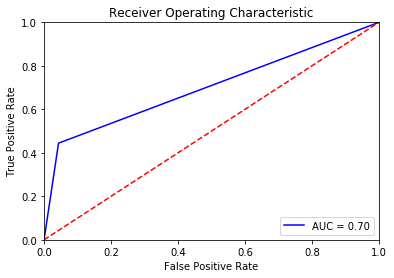

In [65]:
if TEST:
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [66]:
if not TEST:
    StackingSubmission = pd.DataFrame({ 'EmployeeNumber': EmployeeID,
                                        'Attrition': predictions })
    StackingSubmission.to_csv(r"C:\Users\SkunkWorks\Desktop\ML_Challenege\Submission.csv", index=False)